1. Load library

In [1]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report
from imutils import paths
import tensorflow as tf
from tensorflow.keras.applications import VGG16, imagenet_utils
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from sklearn.preprocessing import LabelEncoder, LabelBinarizer
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop, SGD, Adam
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, BatchNormalization, LeakyReLU
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import os

In [2]:
os.chdir("/kaggle/input/dogs-and-cats-agtech/Cat and Dog/Cat and Dog")
print(os.getcwd())

/kaggle/input/dogs-and-cats-agtech/Cat and Dog/Cat and Dog


In [3]:
!ls

test  train  val


In [4]:
generator = ImageDataGenerator(rescale = 1./255)

train_generator = generator.flow_from_directory(  
    directory="/kaggle/input/dogs-and-cats-agtech/Cat and Dog/Cat and Dog/train", 
    target_size=(224, 224),
    batch_size=32, 
    class_mode='categorical',    
    shuffle=True 
) 

valid_generator = generator.flow_from_directory(
    directory="/kaggle/input/dogs-and-cats-agtech/Cat and Dog/Cat and Dog/val", 
    target_size=(224, 224),
    batch_size=32, 
    class_mode='categorical',    
    shuffle=True 
)

image, label = next(train_generator)

print(f"Shape of Batch Size: {image.shape}")

Found 1440 images belonging to 2 classes.
Found 480 images belonging to 2 classes.
Shape of Batch Size: (32, 224, 224, 3)


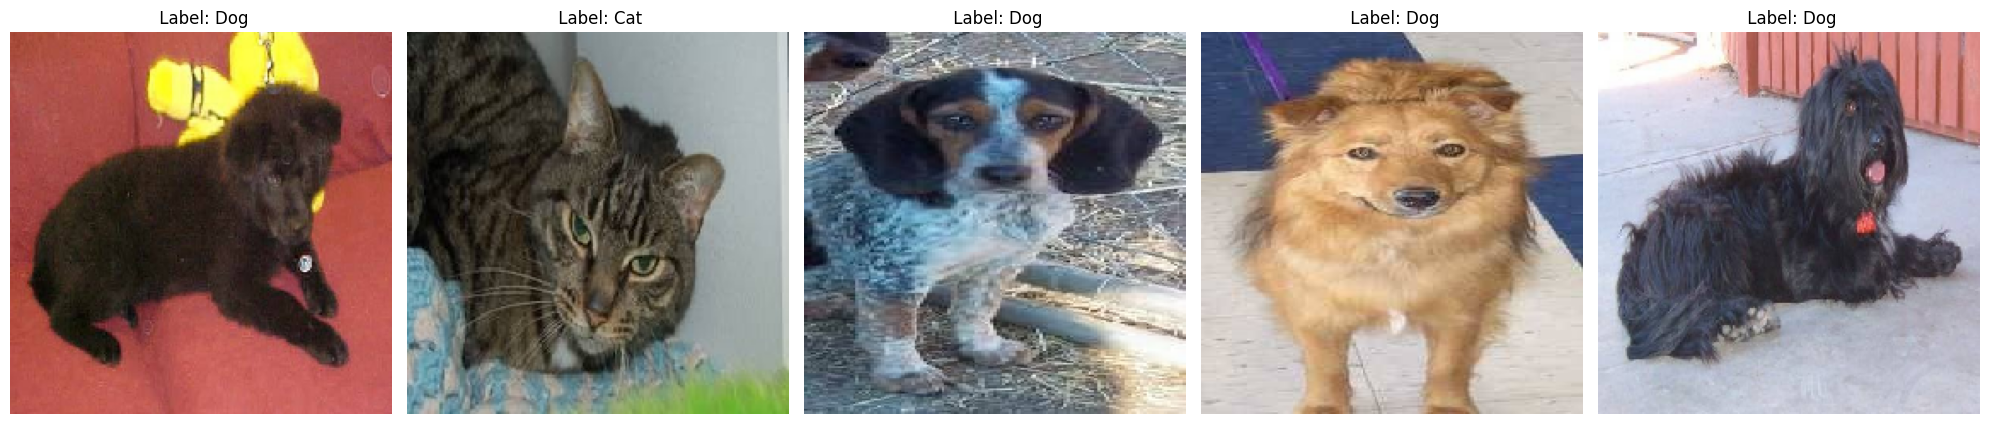

In [5]:
fig, axes = plt.subplots(1, 5, figsize = (20, 20))
for i in range(5):
    axes[i].imshow(image[i])
    axes[i].axis('off')
    axes[i].set_title(f" Label: {'Cat' if (label[i][0] == 1) else 'Dog'}")

plt.tight_layout()
plt.show()

In [6]:
baseModel = VGG16(weights = 'imagenet',
                  include_top = False,
                  input_tensor = Input(shape=(224, 224, 3)))

baseModel.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
fcHead = baseModel.output
fcHead = Flatten(name = 'flatten')(fcHead)

fcHead = Dense(256, activation = None, name = 'dense_layer_1')(fcHead)
fcHead = BatchNormalization()(fcHead)
fcHead = LeakyReLU(negative_slope = 0.01, name = 'leaky_relu_1')(fcHead)
fcHead = Dropout(0.5)(fcHead)

fcHead = Dense(2, activation='softmax', name='output_layer')(fcHead)
model = Model(inputs=baseModel.input, outputs = fcHead)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_layer_1 (Dense)                │ (None, 256)                 │       6,422,784 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 21,139,010 (80.64 MB)

 Trainable params: 21,138,498 (80.64 MB)

 Non-trainable params: 512 (2.00 KB)

In [8]:
for layer in baseModel.layers:
    layer.trainable = False

early_stopping = EarlyStopping(monitor = 'val_accuracy',
                               patience = 5,
                               restore_best_weights = True)

model.compile(optimizer = RMSprop(learning_rate = 0.001, weight_decay = 0.001),
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

numOfEpochs = 20
H = model.fit(train_generator,
              validation_data = valid_generator,
              epochs = numOfEpochs,
              callbacks = [early_stopping],
              verbose = 1)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


45/45 ━━━━━━━━━━━━━━━━━━━━ 31s 299ms/step - accuracy: 0.7712 - loss: 0.6304 - val_accuracy: 0.7958 - val_loss: 0.8338
Epoch 2/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 8s 167ms/step - accuracy: 0.9435 - loss: 0.1363 - val_accuracy: 0.8792 - val_loss: 0.4465
Epoch 3/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 8s 171ms/step - accuracy: 0.9757 - loss: 0.0607 - val_accuracy: 0.8979 - val_loss: 0.3747
Epoch 4/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 8s 175ms/step - accuracy: 0.9916 - loss: 0.0378 - val_accuracy: 0.8896 - val_loss: 0.4185
Epoch 5/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 9s 177ms/step - accuracy: 0.9973 - loss: 0.0185 - val_accuracy: 0.8521 - val_loss: 0.5873
Epoch 6/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 9s 182ms/step - accuracy: 0.9972 - loss: 0.0177 - val_accuracy: 0.8792 - val_loss: 0.4488
Epoch 7/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 9s 188ms/step - accuracy: 0.9978 - loss: 0.0100 - val_accuracy: 0.8813 - val_loss: 0.4084
Epoch 8/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 9s 193ms/step - accuracy: 0.9991 - loss: 0.0076 - val_accuracy: 0.8792 - val

In [9]:
for layer in baseModel.layers[7:]:
    layer.trainable = True

early_stopping = EarlyStopping(monitor = 'val_accuracy',
                               patience = 5,
                               restore_best_weights = True)

model.compile(optimizer = RMSprop(learning_rate = 0.0001, weight_decay = 0.01),
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

numOfEpochs = 20
H = model.fit(train_generator,
              validation_data = valid_generator,
              epochs = numOfEpochs,
              callbacks = [early_stopping],
              verbose = 1)

Epoch 1/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 45s 476ms/step - accuracy: 0.8202 - loss: 0.6415 - val_accuracy: 0.9083 - val_loss: 0.5234
Epoch 2/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 22s 470ms/step - accuracy: 0.9432 - loss: 0.1424 - val_accuracy: 0.9104 - val_loss: 0.5903
Epoch 3/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 21s 454ms/step - accuracy: 0.9643 - loss: 0.0979 - val_accuracy: 0.6729 - val_loss: 2.1408
Epoch 4/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 21s 448ms/step - accuracy: 0.9765 - loss: 0.0814 - val_accuracy: 0.9083 - val_loss: 0.3445
Epoch 5/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 21s 460ms/step - accuracy: 0.9874 - loss: 0.0359 - val_accuracy: 0.7750 - val_loss: 1.4553
Epoch 6/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 21s 463ms/step - accuracy: 0.9903 - loss: 0.0412 - val_accuracy: 0.8813 - val_loss: 0.6447
Epoch 7/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 21s 458ms/step - accuracy: 0.9785 - loss: 0.0519 - val_accuracy: 0.9333 - val_loss: 0.2448
Epoch 8/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 21s 451ms/step - accuracy: 0.9863 - loss: 0.0394 - val_accu

In [11]:
#https://www.kaggle.com/competitions/agtech-ai-hackathon-online-2022-demo
import re

image_test_path = list(paths.list_images('test/'))
idx_image_test = [int(re.findall(r'\d+', path)[0]) for path in image_test_path]
print(f"Test size: {len(image_test_path)}")

list_image = []
with tqdm(total=len(image_test_path), unit='image', unit_scale=True, desc='Loading images') as pbar:
    for (_, path) in enumerate(image_test_path):
        image = load_img(path, target_size=(224, 224))
        image = img_to_array(image)
        image = image*1./255

        image = np.expand_dims(image, axis=0)  
        list_image.append(image)
        pbar.update(1)

list_image = np.vstack(list_image)
print(f"Test shape: {list_image.shape}")

Test size: 480


Loading images: 100%|██████████| 480/480 [00:03<00:00, 155image/s] 


Test shape: (480, 224, 224, 3)


In [12]:
predictions = model.predict(list_image, verbose = 1)

class_mapping = {0: 'cat', 1: 'dog'}
classes = np.argmax(predictions, axis = 1)
classes = [class_mapping[i] for i in classes]

submission_data = pd.DataFrame({"file name" : idx_image_test,
                                "class" : classes})
print(submission_data)

submission_data.to_csv("/kaggle/working/submission.csv", index=False)

15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 154ms/step
     file name class
0          208   cat
1          473   cat
2          333   dog
3           45   cat
4          369   dog
..         ...   ...
475        454   cat
476        364   cat
477         90   dog
478         25   cat
479        147   cat

[480 rows x 2 columns]
